In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score,classification_report,precision_score,accuracy_score,confusion_matrix,recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Prepare data

In [15]:
# Load data (with engineered features)
churn_data = pd.read_csv("churn_data.csv")

# --- Feature Engineering (repeat if not already done) ---
churn_data["TotalCharges"] = pd.to_numeric(churn_data["TotalCharges"], errors="coerce")
churn_data.dropna(subset=["TotalCharges"], inplace=True)
churn_data.drop(columns=["customerID"], inplace=True)
# Binning tenure
churn_data['tenure_bin'] = pd.cut(churn_data['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr'])
# Binning MonthlyCharges
churn_data['MonthlyCharges_bin'] = pd.cut(churn_data['MonthlyCharges'], bins=[0, 35, 70, 105, churn_data['MonthlyCharges'].max()], labels=['Low', 'Medium', 'High', 'Very High'])
# Binning TotalCharges
churn_data['TotalCharges_bin'] = pd.cut(churn_data['TotalCharges'], bins=[0, 1000, 3000, 6000, churn_data['TotalCharges'].max()], labels=['Low', 'Medium', 'High', 'Very High'])
# Encode target variable
churn_data['Churn'] = churn_data['Churn'].map({'No': 0, 'Yes': 1})
# Convert all categorical features to numeric using one-hot encoding
churn_data = pd.get_dummies(churn_data, drop_first=True)
# Display the first few rows and dtypes of the final DataFrame
churn_data.info(5)

X = churn_data.drop('Churn', axis=1)
y = churn_data['Churn']
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)       



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 40 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7032 non-null   int64  
 1   tenure                                 7032 non-null   int64  
 2   MonthlyCharges                         7032 non-null   float64
 3   TotalCharges                           7032 non-null   float64
 4   Churn                                  7032 non-null   int64  
 5   gender_Male                            7032 non-null   uint8  
 6   Partner_Yes                            7032 non-null   uint8  
 7   Dependents_Yes                         7032 non-null   uint8  
 8   PhoneService_Yes                       7032 non-null   uint8  
 9   MultipleLines_No phone service         7032 non-null   uint8  
 10  MultipleLines_Yes                      7032 non-null   uint8  
 11  Inte

# Testing models 

***** Model is Logistic Regression
Accuracy score : 0.7348969438521677
Precision score : 0.5008488964346349
Recall score : 0.7887700534759359
F1 score : 0.612668743509865
RAU score : 0.8300754254002929
***** Model is Decision Tree
Accuracy score : 0.7213930348258707
Precision score : 0.47715736040609136
Recall score : 0.5026737967914439
F1 score : 0.48958333333333337
RAU score : 0.6532631709728686
***** Model is Random Forest
Accuracy score : 0.7874911158493249
Precision score : 0.6425855513307985
Recall score : 0.45187165775401067
F1 score : 0.5306122448979592
RAU score : 0.819470831543037
***** Model is Gradient Boosting
Accuracy score : 0.7945984363894811
Precision score : 0.6523297491039427
Recall score : 0.48663101604278075
F1 score : 0.557427258805513
RAU score : 0.8348043961050055
***** Model is SVM
Accuracy score : 0.7903340440653873
Precision score : 0.6549019607843137
Recall score : 0.446524064171123
F1 score : 0.5310015898251191
RAU score : 0.788474978128187
***** Model is X

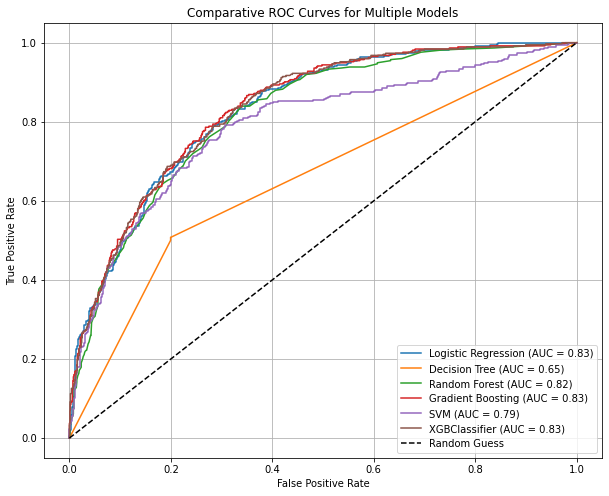

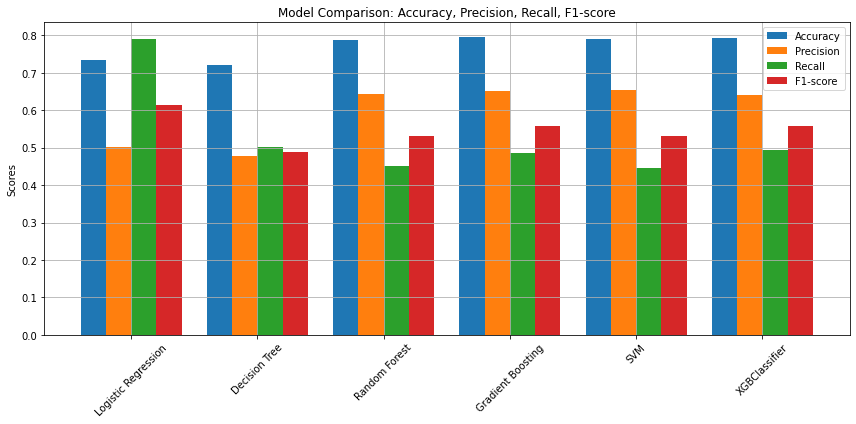

In [16]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced',max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "XGBClassifier": XGBClassifier(use_label_encoder=False,eval_metric="logloss")
}

# Store metrics
metrics = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}
model_names = []

plt.figure(figsize=(10, 8))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    print(f"***** Model is {name}")
    print(f"Accuracy score : {accuracy_score(y_test, y_pred)}")
    print(f"Precision score : {precision_score(y_test, y_pred)}")
    print(f"Recall score : {recall_score(y_test, y_pred)}")
    print(f"F1 score : {f1_score(y_test, y_pred)}")
    print(f"RAU score : {auc}")
    #Plot RAU
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
     # add metrics
    model_names.append(name)
    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["Precision"].append(precision_score(y_test, y_pred))
    metrics["Recall"].append(recall_score(y_test, y_pred))
    metrics["F1-score"].append(f1_score(y_test, y_pred))
    
#Pot RAU curve 
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative ROC Curves for Multiple Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot grouped bar chart
x = np.arange(len(model_names))  # label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 1.5*width, metrics["Accuracy"], width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, metrics["Precision"], width, label='Precision')
rects3 = ax.bar(x + 0.5*width, metrics["Recall"], width, label='Recall')
rects4 = ax.bar(x + 1.5*width, metrics["F1-score"], width, label='F1-score')

# Add labels and title
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: Accuracy, Precision, Recall, F1-score')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Tuning Logistic Regession

In [20]:
# Define parameter grid for Logistic Regression
param_grid = {
    'C': [-4,0.01, 0.1, 1, 10, 100,200,500],
    'penalty': ['l1', 'l2','elasticnet','none'],
    'solver': ['liblinear','lbfgs']  # 'liblinear' supports both l1 and l2 penalties
}
# Initialize Logistic Regression with class_weight='balanced'
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)


# Perform GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [-4, 0.01, 0.1, 1, 10, 100, 200, 500],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['liblinear', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [21]:
# Get the best model and evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)

print("Best Parameters:", grid_search.best_params_)
print(f"ROC AUC Score of Best Model: {roc_auc:.4f}")

print(f"Accuracy score : {accuracy_score(y_test, y_pred)}")
print(f"Precision score : {precision_score(y_test, y_pred)}")
print(f"Recall score : {recall_score(y_test, y_pred)}")
print(f"F1 score : {f1_score(y_test, y_pred)}")
print(f"RAU score : {auc}")

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
ROC AUC Score of Best Model: 0.8313
Accuracy score : 0.736318407960199
Precision score : 0.5025380710659898
Recall score : 0.7941176470588235
F1 score : 0.6155440414507771
RAU score : 0.8330261788777819


# Try with Feature Importance

                                  Feature  Importance
3                            TotalCharges    0.162477
1                                  tenure    0.146536
2                          MonthlyCharges    0.135776
25                      Contract_Two year    0.044365
10            InternetService_Fiber optic    0.041532
28         PaymentMethod_Electronic check    0.029524
24                      Contract_One year    0.027934
4                             gender_Male    0.026137
19                        TechSupport_Yes    0.025773
13                     OnlineSecurity_Yes    0.023947
32                       tenure_bin_4-6yr    0.022425
26                   PaperlessBilling_Yes    0.022077
5                             Partner_Yes    0.021483
6                          Dependents_Yes    0.019156
15                       OnlineBackup_Yes    0.018965
0                           SeniorCitizen    0.018298
9                       MultipleLines_Yes    0.017130
17                   DeviceP

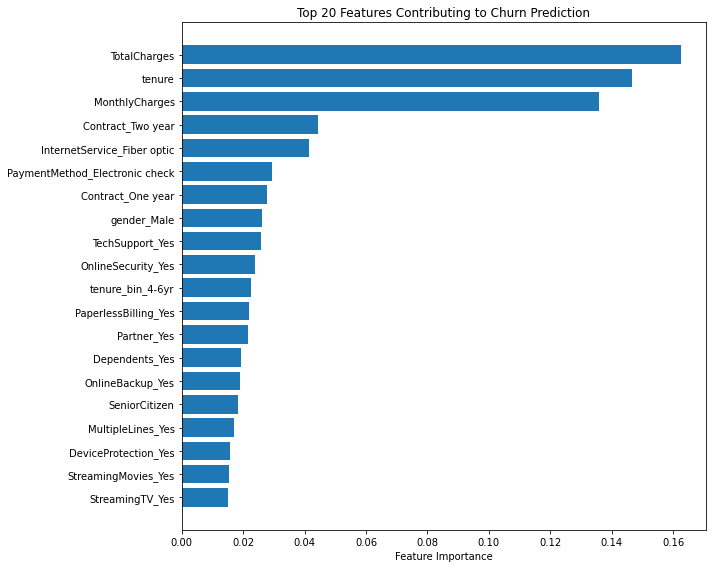

In [23]:
# Get feature importances
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:20][::-1], feature_importance_df['Importance'][:20][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features Contributing to Churn Prediction")
plt.tight_layout()
plt.show()

In [24]:
## Remove features with low importance and train models
importances = pd.Series(rf.feature_importances_, index=X.columns)
important_features = importances[importances > 0.01].sort_values(ascending=False)
removed_features = importances[importances <= 0.01].index.tolist()
print(f"removed Features -  {removed_features}")

# Keep only important features
X_selected = X[important_features.index]
#X_selected.head()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

removed Features -  ['PhoneService_Yes', 'MultipleLines_No phone service', 'InternetService_No', 'OnlineSecurity_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'tenure_bin_1-2yr', 'tenure_bin_2-4yr', 'MonthlyCharges_bin_Medium', 'MonthlyCharges_bin_Very High', 'TotalCharges_bin_Medium', 'TotalCharges_bin_High', 'TotalCharges_bin_Very High']


***** Model is Logistic Regression
Accuracy score : 0.7306325515280739
Precision score : 0.4957841483979764
Recall score : 0.786096256684492
F1 score : 0.6080661840744571
RAU score : 0.8323946140983894
***** Model is Decision Tree
Accuracy score : 0.7135749822316987
Precision score : 0.46365914786967416
Recall score : 0.4946524064171123
F1 score : 0.47865459249676584
RAU score : 0.6432228440086764
***** Model is Random Forest
Accuracy score : 0.7903340440653873
Precision score : 0.6338983050847458
Recall score : 0.5
F1 score : 0.5590433482810164
RAU score : 0.814810452914775
***** Model is Gradient Boosting
Accuracy score : 0.7981520966595593
Precision score : 0.6584507042253521
Recall score : 0.5
F1 score : 0.56838905775076
RAU score : 0.8350425270873993
***** Model is SVM
Accuracy score : 0.7853589196872779
Precision score : 0.6232876712328768
Recall score : 0.48663101604278075
F1 score : 0.5465465465465467
RAU score : 0.7881022513731356
***** Model is XGBClassifier
Accuracy score : 

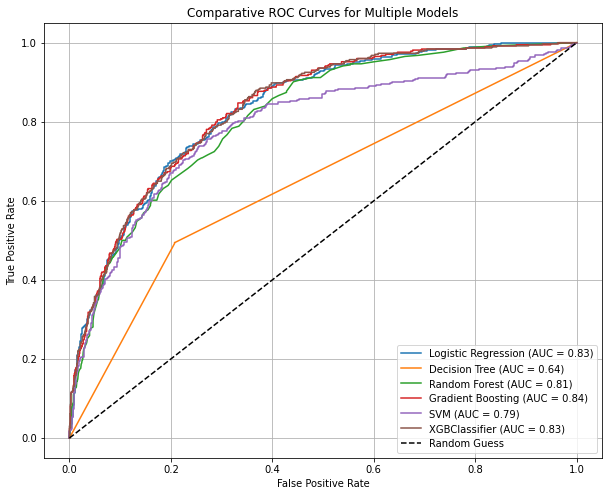

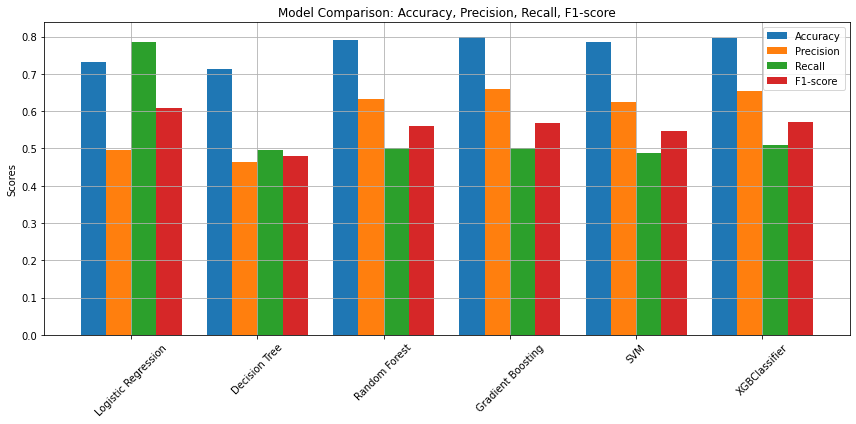

In [25]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced',max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "XGBClassifier": XGBClassifier(use_label_encoder=False,eval_metric="logloss")
}

# Store metrics
metrics = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}
model_names = []

plt.figure(figsize=(10, 8))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    print(f"***** Model is {name}")
    print(f"Accuracy score : {accuracy_score(y_test, y_pred)}")
    print(f"Precision score : {precision_score(y_test, y_pred)}")
    print(f"Recall score : {recall_score(y_test, y_pred)}")
    print(f"F1 score : {f1_score(y_test, y_pred)}")
    print(f"RAU score : {auc}")
    #Plot RAU
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
     # add metrics
    model_names.append(name)
    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["Precision"].append(precision_score(y_test, y_pred))
    metrics["Recall"].append(recall_score(y_test, y_pred))
    metrics["F1-score"].append(f1_score(y_test, y_pred))
    
#Pot RAU curve 
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative ROC Curves for Multiple Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot grouped bar chart
x = np.arange(len(model_names))  # label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 1.5*width, metrics["Accuracy"], width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, metrics["Precision"], width, label='Precision')
rects3 = ax.bar(x + 0.5*width, metrics["Recall"], width, label='Recall')
rects4 = ax.bar(x + 1.5*width, metrics["F1-score"], width, label='F1-score')

# Add labels and title
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: Accuracy, Precision, Recall, F1-score')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()